# CrowdTruth for Sparse Multiple Choice Tasks: Event Extraction

In this tutorial, we will apply CrowdTruth metrics to a **sparse multiple choice** crowdsourcing task for **Event Extraction** from sentences. The workers were asked to read a sentence and then pick from a multiple choice list which are the words or words phrases in the sentence that are events or actions. The options available in the multiple choice list change with the input sentence. The task was executed on [FigureEight](https://www.figure-eight.com/). For more crowdsourcing annotation task examples, click [here](https://raw.githubusercontent.com/CrowdTruth-core/tutorial/getting_started.md).

To replicate this experiment, the code used to design and implement this crowdsourcing annotation template is available here: [template](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/Events-Text-Sparse-Multiple-Choice/template.html), [css](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/Events-Text-Sparse-Multiple-Choice/template.css), [javascript](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/templates/Events-Text-Sparse-Multiple-Choice/template.js). 

This is a screenshot of the task as it appeared to workers:

![Task Template](img/event-text-sparse-multiple-choice.png)

A sample dataset for this task is available in [this file](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/data/event-text-sparse-multiple-choice.csv), containing raw output from the crowd on FigureEight. Download the file and place it in a folder named `data` that has the same root as this notebook. Now you can check your data:

In [1]:
import pandas as pd

test_data = pd.read_csv("data/event-text-sparse-multiple-choice.csv")
test_data.head()

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,...,events_count,original_sentence,processed_sentence,selectedtags_desc_gold,sentence,sentence_id,stanford_lemmas,stanford_pos_tags,tokens,validate_verbs
0,1883297207,8/31/2018 08:18:12,4019711384,8/31/2018 08:11:44,False,clixsense,1,6481150,AUS,8,...,4,"Separately, Esselte Business Systems reported ...","Separately , Esselte Business Systems reported...",NaN,NaN,11,NaN,NaN,39,NaN
1,1883297207,8/31/2018 21:59:16,4021335631,8/31/2018 21:58:58,False,gifthunterclub,1,43861575,USA,NaN,...,4,"Separately, Esselte Business Systems reported ...","Separately , Esselte Business Systems reported...",NaN,NaN,11,NaN,NaN,39,NaN
2,1883297214,8/30/2018 12:57:05,4016914193,8/30/2018 12:56:45,False,clixsense,1,31988217,GBR,P5,...,5,But some other parties and social organization...,But some other parties and social organization...,NaN,NaN,10,NaN,NaN,39,NaN
3,1883297214,8/31/2018 12:36:21,4020056124,8/31/2018 12:35:42,False,instagc,1,23503585,CAN,SK,...,5,But some other parties and social organization...,But some other parties and social organization...,NaN,NaN,10,NaN,NaN,39,NaN
4,1883297214,8/30/2018 15:00:13,4017194252,8/30/2018 14:59:21,False,prodege,1,11131207,CAN,ON,...,5,But some other parties and social organization...,But some other parties and social organization...,NaN,NaN,10,NaN,NaN,39,NaN


## Declaring a pre-processing configuration

The pre-processing configuration defines how to interpret the raw crowdsourcing input. To do this, we need to define a configuration class. First, we import the default CrowdTruth configuration class:

In [2]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

Our test class inherits the default configuration `DefaultConfig`, while also declaring some additional attributes that are specific to the Relation Extraction task:

* **`inputColumns`:** list of input columns from the .csv file with the input data
* **`outputColumns`:** list of output columns from the .csv file with the answers from the workers
* **`annotation_separator`:** string that separates between the crowd annotations in `outputColumns`
* **`open_ended_task`:** boolean variable defining whether the task is open-ended (i.e. the possible crowd annotations are not known beforehand, like in the case of free text input); in the task that we are processing, workers pick the answers from a pre-defined list, therefore the task is not open ended, and this variable is set to `False`
* **`annotation_vector`:** list of possible crowd answers, mandatory to declare when `open_ended_task` is `False`; for our task, this is the list of all relations that were given as input to the crowd in at least one sentence
* **`processJudgments`:** method that defines processing of the raw crowd data; for this task, we process the crowd answers to correspond to the values in `annotation_vector`

The complete configuration class is declared below:

In [3]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

[nltk_data] Downloading package punkt to /Users/oanainel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/oanainel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/oanainel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
def define_annotation_vector(eventsList):
    
    events = []
    for i in range(len(eventsList)):
        currentEvents = eventsList[i].split("###")
        
        for j in range(len(currentEvents)):
            if currentEvents[j] != "no_event":
                
                nltk_tagged = nltk.pos_tag(nltk.word_tokenize(str(currentEvents[j].lower().split("__")[0])))  
                wn_tagged = map(lambda x: (str(x[0]), nltk2wn_tag(x[1])), nltk_tagged)
                res_words = []
                
                for word, tag in wn_tagged:
                    if tag is None:            
                        res_word = wordnet._morphy(str(word), wordnet.NOUN)
                        if res_word == []:
                            res_words.append(str(word))
                        else:
                            if len(res_word) == 1:
                                res_words.append(str(res_word[0]))
                            else:
                                res_words.append(str(res_word[1]))
                    else:
                        res_word = wordnet._morphy(str(word), tag)
                        if res_word == []:
                            res_words.append(str(word))
                        else: 
                            if len(res_word) == 1:
                                res_words.append(str(res_word[0]))
                            else:
                                res_words.append(str(res_word[1]))
                lematized_keyword = " ".join(res_words)
                
                if lematized_keyword not in events:
                    events.append(lematized_keyword)
                    print(events)
    events.append("no_event")   
    return events

In [17]:
define_annotation_vector(["went__1__2###gone__2__3"])

['go']


['go', 'no_event']

In [18]:
def lemmatize_keywords(keywords, separator):
    keywords_list = keywords.split(separator)
    lematized_keywords = []
    
    for keyword in keywords_list:
        nltk_tagged = nltk.pos_tag(nltk.word_tokenize(str(keyword).split("__")[0]))  
        wn_tagged = map(lambda x: (str(x[0]), nltk2wn_tag(x[1])), nltk_tagged)
        res_words = []
        for word, tag in wn_tagged:
            if tag is None:            
                res_word = wordnet._morphy(str(word), wordnet.NOUN)
                if res_word == []:
                    res_words.append(str(word))
                else:
                    if len(res_word) == 1:
                        res_words.append(str(res_word[0]))
                    else:
                        res_words.append(str(res_word[1]))
            else:
                res_word = wordnet._morphy(str(word), tag)
                if res_word == []:
                    res_words.append(str(word))
                else: 
                    if len(res_word) == 1:
                        res_words.append(str(res_word[0]))
                    else:
                        res_words.append(str(res_word[1]))
        lematized_keyword = " ".join(res_words)
        lematized_keywords.append(lematized_keyword)
        
    return separator.join(lematized_keywords)

In [19]:
class TestConfig(DefaultConfig):
    inputColumns = ["doc_id", "events", "events_count", "original_sentence", "processed_sentence", "sentence_id", "tokens"]
    outputColumns = ["selected_events"]
    
    annotation_separator = ","
    annotation_vector = define_annotation_vector(test_data["events"])
        
    # processing of a closed task
    open_ended_task = False
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
            # remove square brackets from annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(']',''))
            # remove the quotes around the annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('"',''))
            judgments[col] = judgments[col].apply(lambda x: lemmatize_keywords(str(x), self.annotation_separator))
        return judgments

['$ 10.1']
['$ 10.1', 'report']
['$ 10.1', 'report', 'fall']
['$ 10.1', 'report', 'fall', '$ 9.5']
['$ 10.1', 'report', 'fall', '$ 9.5', 'be']
['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession']
['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim']
['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring']
['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement']
['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement', 'truth']
['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement', 'truth', 'attempt']
['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement', 'truth', 'attempt', 'analyze']
['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement', 'truth', 'attempt', 'analyze', 'reply']
['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement', 'truth', 'attempt', 'analyze', 

['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement', 'truth', 'attempt', 'analyze', 'reply', 'distort', 'appear', 'announce', 'close', 'request', 'market', 'say', 'produce', 'approve', 'treatment', 'lead', 'target', 'assassination', 'arrest', 'confrontation', 'end', 'proposal', 'assume', 'crisis', 'role', 'offering', 'flow', 'barricade', 'extend', 'told', 'become', 'casualty', 'entrench', 'encounter', 'suffer', 'indication', 'bogged', 'support']
['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement', 'truth', 'attempt', 'analyze', 'reply', 'distort', 'appear', 'announce', 'close', 'request', 'market', 'say', 'produce', 'approve', 'treatment', 'lead', 'target', 'assassination', 'arrest', 'confrontation', 'end', 'proposal', 'assume', 'crisis', 'role', 'offering', 'flow', 'barricade', 'extend', 'told', 'become', 'casualty', 'entrench', 'encounter', 'suffer', 'indication', 'bogged', 'support', 'purport']
['$ 10.1', 'report'

['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement', 'truth', 'attempt', 'analyze', 'reply', 'distort', 'appear', 'announce', 'close', 'request', 'market', 'say', 'produce', 'approve', 'treatment', 'lead', 'target', 'assassination', 'arrest', 'confrontation', 'end', 'proposal', 'assume', 'crisis', 'role', 'offering', 'flow', 'barricade', 'extend', 'told', 'become', 'casualty', 'entrench', 'encounter', 'suffer', 'indication', 'bogged', 'support', 'purport', 'held', 'find', 'believe', 'identify', 'prostitute', 'killing', 'block', 'retaliate', 'boost', 'fill', 'create', 'thrust', 'guard', 'camped', 'continued', 'part', 'buildup', 'likely', 'out', 'off', 'change', 'expect', 'transaction', 'come', 'withdraw', 'meeting', 'hope', 'suit', 'comment', 'confirm', 'head', 'grip']
['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement', 'truth', 'attempt', 'analyze', 'reply', 'distort', 'appear', 'announce', 'close', 'request', 'mark

['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement', 'truth', 'attempt', 'analyze', 'reply', 'distort', 'appear', 'announce', 'close', 'request', 'market', 'say', 'produce', 'approve', 'treatment', 'lead', 'target', 'assassination', 'arrest', 'confrontation', 'end', 'proposal', 'assume', 'crisis', 'role', 'offering', 'flow', 'barricade', 'extend', 'told', 'become', 'casualty', 'entrench', 'encounter', 'suffer', 'indication', 'bogged', 'support', 'purport', 'held', 'find', 'believe', 'identify', 'prostitute', 'killing', 'block', 'retaliate', 'boost', 'fill', 'create', 'thrust', 'guard', 'camped', 'continued', 'part', 'buildup', 'likely', 'out', 'off', 'change', 'expect', 'transaction', 'come', 'withdraw', 'meeting', 'hope', 'suit', 'comment', 'confirm', 'head', 'grip', 'maintain', 'continue', 'tumult', 'disruption', 'withstood', 'cause', 'cut', 'oppose', 'follow', 'raise', 'debate', 'decide', 'kill', 'issue', 'found', 'match', 'bury', 'decline', 'discu

['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement', 'truth', 'attempt', 'analyze', 'reply', 'distort', 'appear', 'announce', 'close', 'request', 'market', 'say', 'produce', 'approve', 'treatment', 'lead', 'target', 'assassination', 'arrest', 'confrontation', 'end', 'proposal', 'assume', 'crisis', 'role', 'offering', 'flow', 'barricade', 'extend', 'told', 'become', 'casualty', 'entrench', 'encounter', 'suffer', 'indication', 'bogged', 'support', 'purport', 'held', 'find', 'believe', 'identify', 'prostitute', 'killing', 'block', 'retaliate', 'boost', 'fill', 'create', 'thrust', 'guard', 'camped', 'continued', 'part', 'buildup', 'likely', 'out', 'off', 'change', 'expect', 'transaction', 'come', 'withdraw', 'meeting', 'hope', 'suit', 'comment', 'confirm', 'head', 'grip', 'maintain', 'continue', 'tumult', 'disruption', 'withstood', 'cause', 'cut', 'oppose', 'follow', 'raise', 'debate', 'decide', 'kill', 'issue', 'found', 'match', 'bury', 'decline', 'discu

['$ 10.1', 'report', 'fall', '$ 9.5', 'be', 'accession', 'claim', 'bring', 'statement', 'truth', 'attempt', 'analyze', 'reply', 'distort', 'appear', 'announce', 'close', 'request', 'market', 'say', 'produce', 'approve', 'treatment', 'lead', 'target', 'assassination', 'arrest', 'confrontation', 'end', 'proposal', 'assume', 'crisis', 'role', 'offering', 'flow', 'barricade', 'extend', 'told', 'become', 'casualty', 'entrench', 'encounter', 'suffer', 'indication', 'bogged', 'support', 'purport', 'held', 'find', 'believe', 'identify', 'prostitute', 'killing', 'block', 'retaliate', 'boost', 'fill', 'create', 'thrust', 'guard', 'camped', 'continued', 'part', 'buildup', 'likely', 'out', 'off', 'change', 'expect', 'transaction', 'come', 'withdraw', 'meeting', 'hope', 'suit', 'comment', 'confirm', 'head', 'grip', 'maintain', 'continue', 'tumult', 'disruption', 'withstood', 'cause', 'cut', 'oppose', 'follow', 'raise', 'debate', 'decide', 'kill', 'issue', 'found', 'match', 'bury', 'decline', 'discu

## Pre-processing the input data

After declaring the configuration of our input file, we are ready to pre-process the crowd data:

In [20]:
data, config = crowdtruth.load(
    file = "data/event-text-sparse-multiple-choice.csv",
    config = TestConfig()
)

data['judgments'].head()

,output.selected_events,output.selected_events.count,output.selected_events.unique,submitted,started,worker,unit,duration,job
judgment,,,,,,,,,
4019711384,"{u'$ 10.1': 1, u'report': 1, u'fall': 1, u'$ 9...",4,143,2018-08-31 08:18:12,2018-08-31 08:11:44,6481150,1883297207,388,data/event-text-sparse-multiple-choice
4021335631,"{u'$ 10.1': 1, u'report': 0, u'fall': 0, u'$ 9...",1,143,2018-08-31 21:59:16,2018-08-31 21:58:58,43861575,1883297207,18,data/event-text-sparse-multiple-choice
4016914193,"{u'accession': 1, u'bring': 1, u'$ 10.1': 0, u...",2,143,2018-08-30 12:57:05,2018-08-30 12:56:45,31988217,1883297214,20,data/event-text-sparse-multiple-choice
4020056124,"{u'accession': 1, u'bring': 1, u'$ 10.1': 0, u...",2,143,2018-08-31 12:36:21,2018-08-31 12:35:42,23503585,1883297214,39,data/event-text-sparse-multiple-choice
4017194252,"{u'accession': 1, u'claim': 1, u'bring': 1, u'...",3,143,2018-08-30 15:00:13,2018-08-30 14:59:21,11131207,1883297214,52,data/event-text-sparse-multiple-choice


In [21]:
data["judgments"]["output.selected_events"].iloc[0]

OrderedCounter({'$ 10.1': 1,
                '$ 9.5': 1,
                'accession': 0,
                'add': 0,
                'analyze': 0,
                'announce': 0,
                'appear': 0,
                'approve': 0,
                'arrest': 0,
                'assassination': 0,
                'assume': 0,
                'attempt': 0,
                'barricade': 0,
                'be': 0,
                'become': 0,
                'believe': 0,
                'block': 0,
                'bogged': 0,
                'boost': 0,
                'bring': 0,
                'buildup': 0,
                'bury': 0,
                'call': 0,
                'camped': 0,
                'casualty': 0,
                'cause': 0,
                'change': 0,
                'claim': 0,
                'close': 0,
                'come': 0,
                'comment': 0,
                'confirm': 0,
                'confrontation': 0,
                'continue': 0,
 

## Computing the CrowdTruth metrics

The pre-processed data can then be used to calculate the CrowdTruth metrics:

In [22]:
results = crowdtruth.run(data, config)

`results` is a dict object that contains the quality metrics for sentences, relations and crowd workers.

The **sentence metrics** are stored in `results["units"]`:

In [23]:
results["units"].head()

,duration,input.doc_id,input.events,input.events_count,input.original_sentence,input.processed_sentence,input.sentence_id,input.tokens,job,output.selected_events,output.selected_events.annotations,output.selected_events.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,,,,
1883297207,80.90,wsj_1033.tml,$ 10.1__129__135###reported__38__46###fell__72...,4,"Separately, Esselte Business Systems reported ...","Separately , Esselte Business Systems reported...",11,39,data/event-text-sparse-multiple-choice,"{u'shot': 0, u'help': 0, u'forbidden': 0, u'se...",35,4,20,0.846166,"{u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...",0.731037,"{u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0..."
1883297208,62.70,APW19990607.0041.tml,purports__5__13###be__17__19###said__179__183#...,5,"Kopp purports to be a devout Roman Catholic, a...","Kopp purports to be a devout Roman Catholic , ...",14,39,data/event-text-sparse-multiple-choice,"{u'shot': 0, u'help': 0, u'forbidden': 0, u'se...",50,5,20,0.576976,"{u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...",0.467344,"{u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0..."
1883297209,49.65,NYT19981025.0216.tml,protect__45__52###murdered__77__85###said__97_...,7,``We as Christians have a responsibility to pr...,`` We as Christians have a responsibility to p...,14,39,data/event-text-sparse-multiple-choice,"{u'shot': 0, u'help': 0, u'forbidden': 0, u'se...",63,6,20,0.719575,"{u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...",0.561513,"{u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0..."
1883297210,63.65,NYT19981026.0446.tml,opposed__170__177###followed__122__130###was__...,5,Slepian's death was among the first topics rai...,Slepian 's death was among the first topics ra...,16,39,data/event-text-sparse-multiple-choice,"{u'shot': 0, u'help': 0, u'forbidden': 0, u'se...",48,5,20,0.655724,"{u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...",0.518003,"{u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0..."
1883297211,39.60,NYT19981026.0446.tml,exploit__109__116###murder__133__139###said__2...,5,``It's possible that New York politics has nev...,`` It 's possible that New York politics has n...,43,39,data/event-text-sparse-multiple-choice,"{u'shot': 0, u'help': 0, u'forbidden': 0, u'se...",52,5,20,0.703147,"{u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...",0.589756,"{u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0..."


The `uqs` column in `results["units"]` contains the **sentence quality scores**, capturing the overall workers agreement over each sentence. Here we plot its histogram:

Text(0,0.5,u'Sentences')

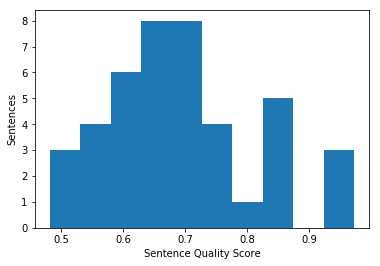

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(results["units"]["uqs"])
plt.xlabel("Sentence Quality Score")
plt.ylabel("Sentences")

The `unit_annotation_score` column in `results["units"]` contains the **sentence-relation scores**, capturing the likelihood that a relation is expressed in a sentence. For each sentence, we store a dictionary mapping each relation to its sentence-relation score.

In [25]:
results["units"]["unit_annotation_score"].head(10)

unit
1883297207    {u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...
1883297208    {u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...
1883297209    {u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...
1883297210    {u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...
1883297211    {u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...
1883297212    {u'shot': 0.928504015089, u'help': 0.0, u'forb...
1883297213    {u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...
1883297214    {u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...
1883297215    {u'shot': 0.0, u'help': 0.447640043562, u'forb...
1883297216    {u'shot': 0.0, u'help': 0.0, u'forbidden': 0.0...
Name: unit_annotation_score, dtype: object

The **worker metrics** are stored in `results["workers"]`:

In [26]:
results["workers"].head()

,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
worker,,,,,,,,,,
1883983,34.500000,1,6,6,0.824251,0.842992,0.977768,0.722426,0.754811,0.957095
3587109,11.000000,1,2,2,0.622879,0.751163,0.829219,0.513732,0.648339,0.792383
4316379,24.000000,1,3,3,0.514888,0.686550,0.749964,0.383277,0.559880,0.684569
6377879,64.666667,1,6,6,0.618776,0.726055,0.852244,0.498032,0.620033,0.803234
6481150,98.047619,1,42,42,0.794510,0.818657,0.970504,0.660539,0.709276,0.931286


The `wqs` columns in `results["workers"]` contains the **worker quality scores**, capturing the overall agreement between one worker and all the other workers.

Text(0,0.5,u'Workers')

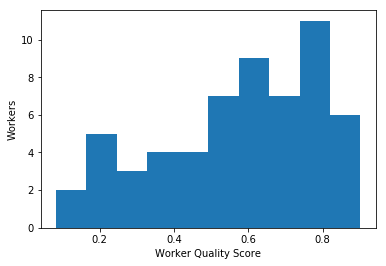

In [27]:
plt.hist(results["workers"]["wqs"])
plt.xlabel("Worker Quality Score")
plt.ylabel("Workers")

The **relation metrics** are stored in `results["annotations"]`. The `aqs` column contains the **relation quality scores**, capturing the overall worker agreement over one relation.

In [28]:
results["annotations"]

,output.selected_events,aqs,aqs_initial
$ 10.1,840,3.819172e-02,5.263158e-02
$ 9.5,840,1.000000e-08,1.000000e-08
accession,840,8.321034e-01,6.842105e-01
add,840,1.936832e-01,2.105263e-01
analyze,840,8.530456e-01,7.894737e-01
announce,840,8.670445e-01,7.368421e-01
appear,840,2.689285e-01,2.105263e-01
approve,840,8.577278e-01,7.894737e-01
arrest,840,8.741370e-01,7.894737e-01
assassination,840,6.594177e-01,5.789474e-01
